# 1. 라이브러리 및 데이터

In [132]:
import pandas as pd
import lightgbm as lgb

In [133]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/ml/dacon/영화관객수예측연습/movies/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/ml/dacon/영화관객수예측연습/movies/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/ml/dacon/영화관객수예측연습/movies/submission.csv')

# 2. EDA

In [134]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


Column_name Description  
1 title : 영화의 제목  
2 distributor : 배급사  
3 genre : 장르    
4 release_time : 개봉일  
5 time : 상영시간(분)  
6 screening_rat : 상영등급  
7 director : 감독이름  
8 dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)  
9 dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)   
10 num_staff : 스텝수  
11 num_actor : 주연배우수  
12 box_off_num : 관객수  

In [135]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [136]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [137]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


In [138]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [139]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [140]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
time,600.0,1.008633e+02,1.809753e+01,45.0,89.00,100.000,114.000,180.0
dir_prev_bfnum,270.0,1.050443e+06,1.791408e+06,1.0,20380.00,478423.625,1286568.625,17615314.0
dir_prev_num,600.0,8.766667e-01,1.183409e+00,0.0,0.00,0.000,2.000,5.0
num_staff,600.0,1.511183e+02,1.656547e+02,0.0,17.00,82.500,264.000,869.0
num_actor,600.0,3.706667e+00,2.446889e+00,0.0,2.00,3.000,4.000,25.0
box_off_num,600.0,7.081818e+05,1.828006e+06,1.0,1297.25,12591.000,479886.750,14262766.0


In [141]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
time,243.0,109.798354,1.240227e+02,40.0,91.0,104.0,1.145000e+02,2015.0
dir_prev_bfnum,107.0,891669.516044,1.217341e+06,34.0,62502.0,493120.0,1.080850e+06,6173099.5
dir_prev_num,243.0,0.851852,1.200321e+00,0.0,0.0,0.0,1.000000e+00,6.0
num_staff,243.0,159.316872,1.629766e+02,0.0,18.0,105.0,2.820000e+02,776.0
num_actor,243.0,3.477366,2.111192e+00,0.0,2.0,3.0,4.000000e+00,16.0


In [142]:
pd.options.display.float_format = '{:.1f}'.format

In [143]:
# 장르별 관객수
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


- 상관계수: 두 개의 변수가 같이 일어나는 강도를 나타내는 수치  
-1에서 1사이의 값을 지닙니다.
-1이나 1인 수치는 현실 세계에서 관측되기 힘든 수치입니다.
- 분야별로 기준을 정하는 것에 따라 달라지겠지만, 보통 0.4이상이면 두 개의 변수간에 상관성이 있다고 얘기합니다.
-상관관계는 인과관계가 아님

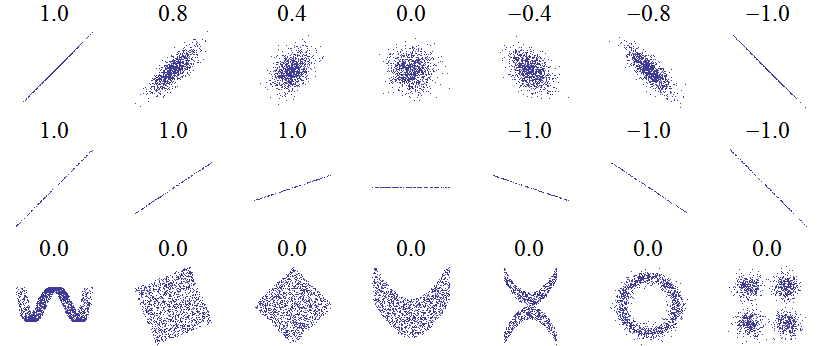

In [144]:
pd.reset_option('display.float_format')

In [145]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


In [146]:
import seaborn as sns

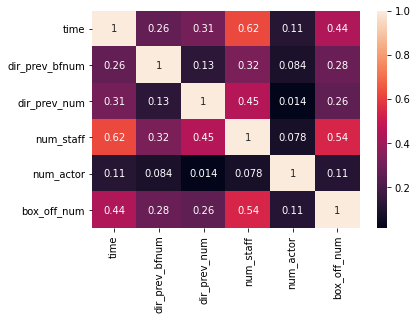

In [147]:
sns.heatmap(train.corr(), annot=True)

box_off_num과 상관관계있는 변수 : time, num_staff

In [148]:
# heatmap 사용 불가 시
corr_mat = train.corr()
corr_mat['box_off_num'].sort_values(ascending =False)

box_off_num       1.000000
num_staff         0.544265
time              0.441452
dir_prev_bfnum    0.283184
dir_prev_num      0.259674
num_actor         0.111179
Name: box_off_num, dtype: float64

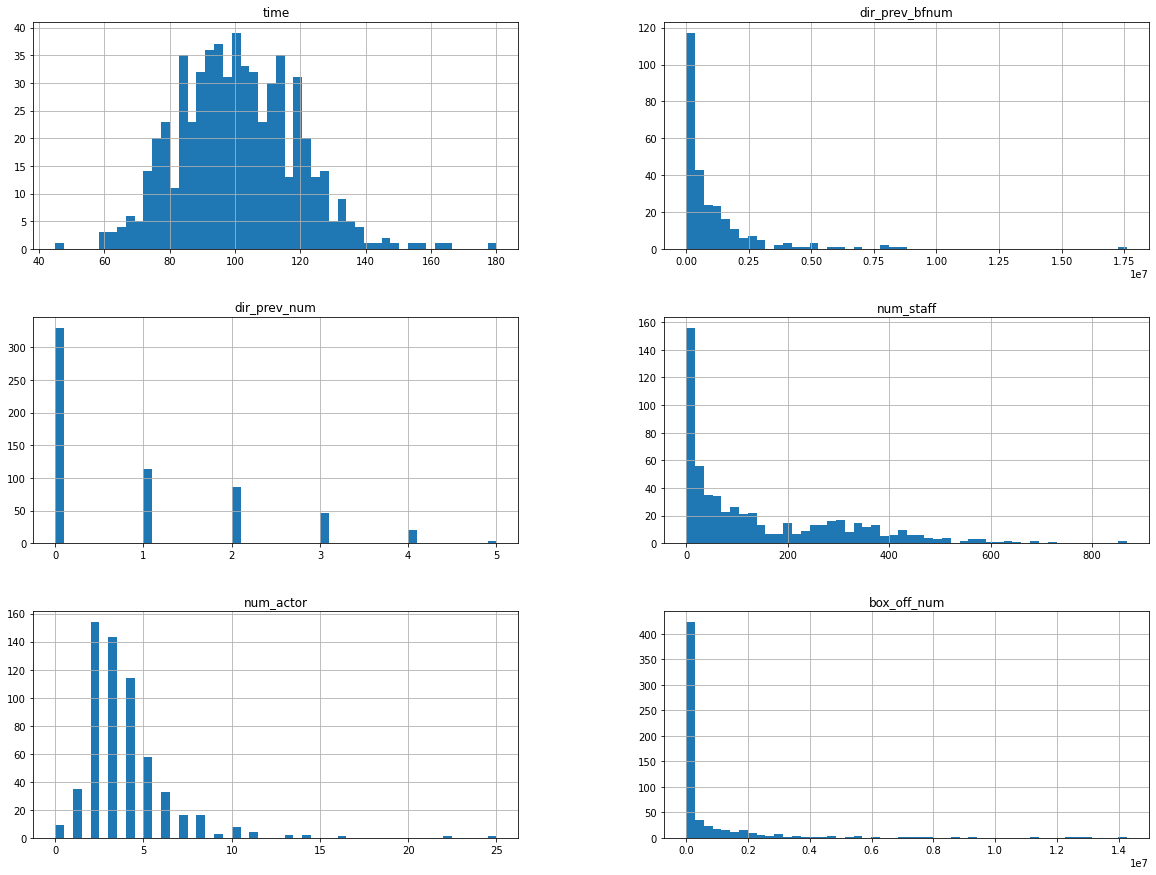

In [149]:
# 히스토그램
import matplotlib.pyplot as plt
%matplotlib inline

train.hist(bins = 50, figsize = (20,15))
plt.show()

# 2.전처리

In [150]:
train.isna().sum() / 600 #총 로우수로 나누면 퍼센트

title             0.00
distributor       0.00
genre             0.00
release_time      0.00
time              0.00
screening_rat     0.00
director          0.00
dir_prev_bfnum    0.55
dir_prev_num      0.00
num_staff         0.00
num_actor         0.00
box_off_num       0.00
dtype: float64

In [151]:
train[train['dir_prev_bfnum'].isna()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745
...,...,...,...,...,...,...,...,...,...,...,...,...
593,낭만파 남편의 편지,퍼스트런,미스터리,2013-09-12,97,청소년 관람불가,최위안,NaN,0,5,3,1132
594,오빠가 돌아왔다,(주)마운틴픽쳐스,코미디,2014-03-20,94,청소년 관람불가,노진수,NaN,0,37,5,1958
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


결측치가 있는 행의 dir_prev_num 이 모두 0임
--> 모든 데이터가 0인지 확인하기

In [152]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

모두 0이므로 해당 감독이 이전에 만든 영화가 없는 경우에만 결측치가 생김 -> 0으로 대체

In [153]:
train['dir_prev_bfnum'].fillna(0, inplace=True)

In [154]:
# test set도 전처리
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [155]:
test[test['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [156]:
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [157]:
test.isna().sum() / len(test)

title             0.0
distributor       0.0
genre             0.0
release_time      0.0
time              0.0
screening_rat     0.0
director          0.0
dir_prev_bfnum    0.0
dir_prev_num      0.0
num_staff         0.0
num_actor         0.0
dtype: float64

# 3. 모델링 - 변수 선택 및 모델 구축


LightGBM  
- 부스팅 모델  
- 기존 모델이 못 맞춘 문제에 가중치를 두어 지속적으로 학습 이어나감  
- 타 부스팅 모델에 비해 속도가 빠름  
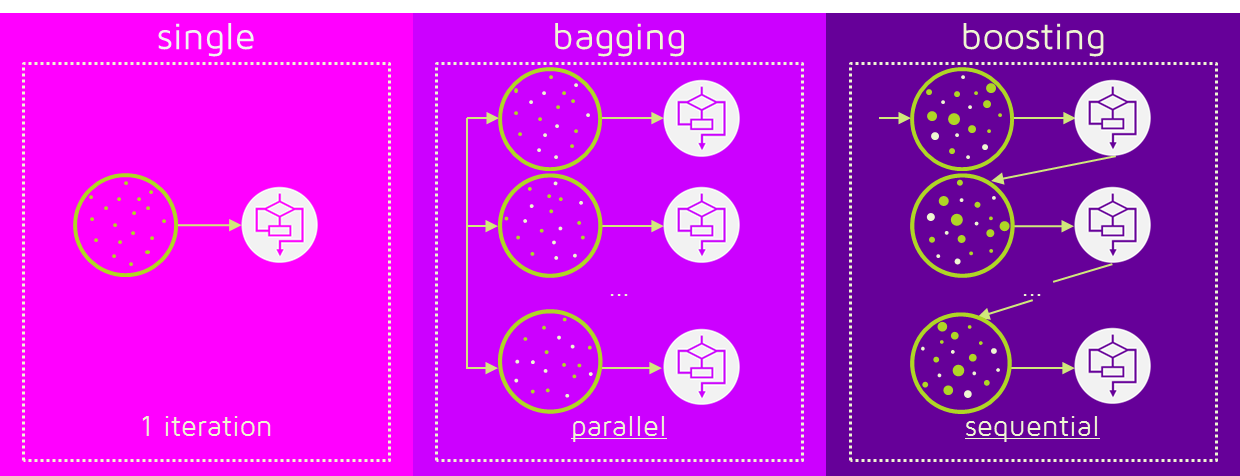

In [35]:
model=lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [36]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [37]:
X_train ,X_test, y_train = train[features], test[features], train[target]

# 4. 모델 학습 및 검증


a. lightGBM (base model)  
b. k-fold lightGBM (k-fold model)  
c. feature engineering (fe)  
d. grid search (hyperparameter tuning)  

In [38]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=777, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
singleLGBM = submission.copy()
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [41]:
singleLGBM['box_off_num'] = model.predict(X_test)
singleLGBM.head()

,title,box_off_num
0,용서는 없다,2.817995e+06
1,아빠가 여자를 좋아해,3.753772e+05
2,하모니,-5.693243e+05
3,의형제,1.581189e+06
4,평행 이론,-5.277806e+05


음수값나온거보니까 모델 성능 안좋겠다

In [42]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

## k-fold 
- 과대적합 방지
- 모델 간 일반적인 성능 비교
- validation set, development set
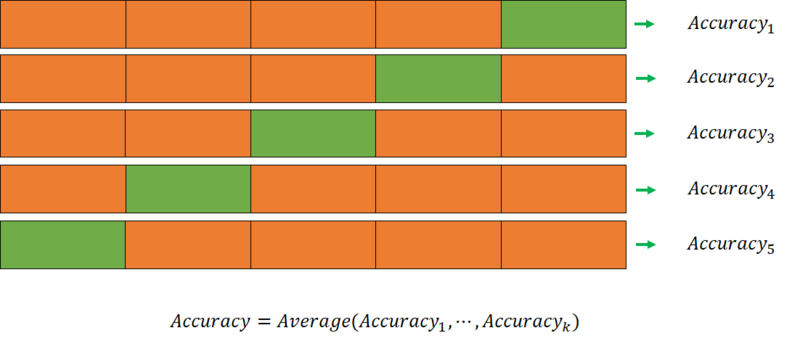

In [158]:
from sklearn.model_selection import KFold

In [159]:
k_fold = KFold(n_splits=5, shuffle = True, random_state=777)

In [46]:
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)

models = []
for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.70572e+12
Early stopping, best iteration is:
[6]	valid_0's l2: 2.45438e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.90847e+12
Early stopping, best iteration is:
[33]	valid_0's l2: 3.72825e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.50344e+12
Early stopping, best iteration is:
[8]	valid_0's l2: 2.58737e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.45977e+12
Early stopping, best iteration is:
[11]	valid_0's l2: 1.26226e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.77214e+12
Early stopping, best iteration is:
[22]	valid_0's l2: 1.57631e+12


In [47]:
preds = []
for md in models:
    preds.append(md.predict(X_test))
len(preds)

5

In [48]:
kfold_LGBM = submission.copy()

In [160]:
import numpy as np

In [50]:
kfold_LGBM['box_off_num'] = np.mean(preds, axis = 0)

In [51]:
kfold_LGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


In [52]:
kfold_LGBM.to_csv('kfoldLGBM.csv', index=False)

## feature engineering

In [161]:
features

['time',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'dir_prev_bfnum',
 'genre_rank',
 'dist_rank',
 'screening_rat']

In [162]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object')

In [163]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [164]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])
train.genre

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int64

In [165]:
test['genre'] = le.transform(test['genre']) # transform만 하기!
test['genre']

0       2
1       5
2       4
3      10
4       1
       ..
238     4
239     3
240     2
241     4
242     5
Name: genre, Length: 243, dtype: int64

In [166]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor','dir_prev_bfnum', 'genre']

In [63]:
X_train, X_test,y_train = train[features], test[features], train[target]

In [64]:
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)

models = []
for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.62067e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.42668e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.39227e+12
Early stopping, best iteration is:
[23]	valid_0's l2: 3.97173e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.29841e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 2.53643e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.56499e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 1.21201e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.60118e+12
Early stopping, best iteration is:
[29]	valid_0's l2: 1.47528e+12


In [65]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum,genre
0,125,2,304,3,3.005290e+05,2
1,113,4,275,3,3.427002e+05,5
2,115,3,419,7,4.206611e+06,4
3,116,2,408,2,6.913420e+05,10
4,110,1,380,1,3.173800e+04,1


In [66]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [67]:
feLightGBM = submission.copy()

In [68]:
feLightGBM['box_off_num'] = np.mean(preds,axis = 0)

In [69]:
feLightGBM.to_csv('feLGBM.csv', index=False)

## grid search

In [167]:
from sklearn.model_selection import GridSearchCV

In [71]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'min_child_samples': [20,30]
}

gs = GridSearchCV(estimator=model, 
                  param_grid = params,
                  scoring = 'neg_mean_squared_error',
                  cv=k_fold)

In [72]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=1000, n_jobs=-1,
                                     num_leaves=31, objective=None,
                                     random_state=777, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                    

In [73]:
gs.best_params_

{'learning_rate': 0.001, 'min_child_samples': 30}

In [74]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000, learning_rate=0.001, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.6981e+12
[200]	valid_0's l2: 2.62546e+12
[300]	valid_0's l2: 2.56718e+12
[400]	valid_0's l2: 2.51397e+12
[500]	valid_0's l2: 2.47666e+12
[600]	valid_0's l2: 2.45634e+12
[700]	valid_0's l2: 2.44526e+12
[800]	valid_0's l2: 2.43828e+12
[900]	valid_0's l2: 2.42849e+12
[1000]	valid_0's l2: 2.42601e+12
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 2.42591e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 5.39165e+12
[200]	valid_0's l2: 5.12207e+12
[300]	valid_0's l2: 4.89262e+12
[400]	valid_0's l2: 4.69817e+12
[500]	valid_0's l2: 4.53817e+12
[600]	valid_0's l2: 4.40999e+12
[700]	valid_0's l2: 4.32616e+12
[800]	valid_0's l2: 4.25195e+12
[900]	valid_0's l2: 4.19287e+12
[1000]	valid_0's l2: 4.14293e+12
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 4.14293e+12
Training until validation scores don't improve for 100 rounds.
[100]	val

In [75]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [76]:
gs.best_score_

-2403275399392.089

In [80]:
np.sqrt(-gs.best_score_)

1550250.1086573382

In [77]:
gslgbm = submission.copy()

In [78]:
gslgbm['box_off_num'] = np.mean(preds, axis = 0)

In [79]:
gslgbm.to_csv('gsLGBM.csv', index=False)

## feature engineering more

In [168]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']

In [169]:
train.distributor.unique()

array(['롯데엔터테인먼트', '(주)쇼박스', '(주)NEW', '쇼박스(주)미디어플렉스', '백두대간',
       '유니버설픽쳐스인터내셔널코리아', '(주)두타연', '(주) 케이알씨지', '(주)콘텐츠 윙', '(주)키노아이',
       '(주)팝 파트너스', 'CJ E&M 영화부문', '(주) 영화제작전원사', 'CJ E&M Pictures',
       'CGV 무비꼴라쥬', '리틀빅픽처스', '스폰지', 'CJ 엔터테인먼트', 'CGV아트하우스', '조이앤시네마',
       '인디플러그', '콘텐츠판다', '인디스토리', '(주)팝엔터테인먼트', '시네마서비스', '웃기씨네',
       '영화사 진진', '(주)레인보우 팩토리', '김기덕 필름', 'NEW', 'CJ CGV',
       '동국대학교 충무로영상제작센터', 'BoXoo 엔터테인먼트', '(주)마운틴픽쳐스', 'CGV 아트하우스',
       '메가박스(주)플러스엠', '골든타이드픽처스', '파이오니아21', '디 씨드', '드림팩트 엔터테인먼트', '시너지',
       '디마엔터테인먼트', '판다미디어', '(주)스톰픽쳐스코리아', '(주)예지림 엔터테인먼트', '(주) 영화사조제',
       '보람엔터테인먼트', '(주)시네마달', '노바엔터테인먼트', '(주)패스파인더씨앤씨', '(주)대명문화공장',
       '(주)온비즈넷', 'KT&G 상상마당', '무비꼴라쥬', '인벤트 디', '씨네그루(주)키다리이엔티',
       '스튜디오후크', '시네마 달', '나이너스엔터테인먼트(주)', 'THE 픽쳐스', '영구아트무비', '리틀빅픽쳐스',
       '어뮤즈', '이모션 픽처스', '(주)이스트스카이필름', '필라멘트 픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹',
       '마운틴 픽처스', '(주)휘엔터테인먼트', '이십세기폭스코리아(주)', '(주)피터팬픽쳐스', '에스와이코마드',
       '(주)더픽쳐스', '오퍼스픽쳐스'

In [170]:
# 배급사 전처리
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [171]:
import re

train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [172]:
train.distributor.unique()

array(['롯데엔터테인먼트', '쇼박스', 'NEW', '쇼박스미디어플렉스', '백두대간', '유니버설픽쳐스인터내셔널코리아',
       '두타연', '케이알씨지', '콘텐츠윙', '키노아이', '팝파트너스', 'CJEM영화부문', '영화제작전원사',
       'CJEMPictures', 'CGV무비꼴라쥬', '리틀빅픽처스', '스폰지', 'CJ엔터테인먼트',
       'CGV아트하우스', '조이앤시네마', '인디플러그', '콘텐츠판다', '인디스토리', '팝엔터테인먼트',
       '시네마서비스', '웃기씨네', '영화사진진', '레인보우팩토리', '김기덕필름', 'CJCGV',
       '동국대학교충무로영상제작센터', 'BoXoo엔터테인먼트', '마운틴픽쳐스', '메가박스플러스엠', '골든타이드픽처스',
       '파이오니아21', '디씨드', '드림팩트엔터테인먼트', '시너지', '디마엔터테인먼트', '판다미디어',
       '스톰픽쳐스코리아', '예지림엔터테인먼트', '영화사조제', '보람엔터테인먼트', '시네마달', '노바엔터테인먼트',
       '패스파인더씨앤씨', '대명문화공장', '온비즈넷', 'KTG상상마당', '무비꼴라쥬', '인벤트디',
       '씨네그루키다리이엔티', '스튜디오후크', '나이너스엔터테인먼트', 'THE픽쳐스', '영구아트무비', '리틀빅픽쳐스',
       '어뮤즈', '이모션픽처스', '이스트스카이필름', '필라멘트픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹',
       '마운틴픽처스', '휘엔터테인먼트', '이십세기폭스코리아', '피터팬픽쳐스', '에스와이코마드', '더픽쳐스',
       '오퍼스픽쳐스', '고앤고필름', '사람과사람들', 'JK필름', '씨너스엔터테인먼트', 'KT', '싸이더스FNH',
       '프레인글로벌', '나우콘텐츠', '홀리가든', '브릿지웍스', '엣나인필름', '위더스필름', '에이원엔터테인먼트',
       'OAL올', '싸이더스

In [173]:
# 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

train.groupby('distributor').box_off_num.median().sort_values()

distributor
인피니티엔터테인먼트            2.0
고구마공작소                8.0
사람과사람들               42.0
위드시네마                46.0
나우콘텐츠                54.0
                  ...    
CJEM영화부문        2242510.0
영구아트무비          2541603.0
쇼박스미디어플렉스       2634823.0
아이필름코퍼레이션       3117859.0
CJEMPictures    4122337.0
Name: box_off_num, Length: 159, dtype: float64

In [174]:
dist_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'dist_rank').sort_values(by = 'dist_rank')
dist_rank

,distributor,dist_rank
122,인피니티엔터테인먼트,2.0
21,고구마공작소,8.0
61,사람과사람들,42.0
109,위드시네마,46.0
25,나우콘텐츠,54.0
...,...,...
5,CJEM영화부문,2242510.0
96,영구아트무비,2541603.0
66,쇼박스미디어플렉스,2634823.0
87,아이필름코퍼레이션,3117859.0


In [175]:
dist_rank['dist_rank'] = [i+1 for i in range(dist_rank.shape[0])]
dist_rank

,distributor,dist_rank
122,인피니티엔터테인먼트,1
21,고구마공작소,2
61,사람과사람들,3
109,위드시네마,4
25,나우콘텐츠,5
...,...,...
5,CJEM영화부문,155
96,영구아트무비,156
66,쇼박스미디어플렉스,157
87,아이필름코퍼레이션,158


In [176]:
# 장르별 관객 수 평균값으로 랭크 인코딩

train.groupby('genre').box_off_num.mean().sort_values()


genre
6     6.627000e+03
3     6.717226e+04
8     8.261100e+04
9     1.819267e+05
5     4.259680e+05
7     5.275482e+05
1     5.908325e+05
4     6.256898e+05
11    1.193914e+06
0     1.788346e+06
10    2.203974e+06
2     2.263695e+06
Name: box_off_num, dtype: float64

In [177]:
train['genre_rank'] = train.genre.map({6 : 1, 3 : 2, 8 : 3, 9 : 4, 5 : 5,
                                      7 : 6, 1 : 7, 4 : 8, 11 : 9, 0 : 10, 10 : 11, 2 : 12})
test['genre_rank'] = test.genre.map({6 : 1, 3 : 2, 8 : 3, 9 : 4, 5 : 5,
                                      7 : 6, 1 : 7, 4 : 8, 11 : 9, 0 : 10, 10 : 11, 2 : 12})

In [178]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank
0,개들의 전쟁,롯데엔터테인먼트,10,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11
1,내부자들,쇼박스,2,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12
2,은밀하게 위대하게,쇼박스,10,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11
3,나는 공무원이다,NEW,11,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9
4,불량남녀,쇼박스미디어플렉스,11,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,9


In [179]:
train = pd.merge(train, dist_rank, how = 'left')
test = pd.merge(test, dist_rank, how= 'left')

In [180]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
genre_rank        0
dist_rank         0
dtype: int64

In [181]:
test.isna().sum()

title              0
distributor        0
genre              0
release_time       0
time               0
screening_rat      0
director           0
dir_prev_bfnum     0
dir_prev_num       0
num_staff          0
num_actor          0
genre_rank         0
dist_rank         33
dtype: int64

In [182]:
test[test['dist_rank'].isna()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,genre_rank,dist_rank
5,회오리 바람,모쿠슈라,4,2010-02-25,95,15세 관람가,장건재,0.0,0,156,2,8,NaN
7,이웃집 남자,루믹스미디어,4,2010-03-18,100,청소년 관람불가,장동홍,0.0,0,117,5,8,NaN
9,반가운 살인자,롯데쇼핑롯데엔터테인먼트,11,2010-04-08,107,15세 관람가,김동욱,0.0,0,255,3,9,NaN
12,작은 연못,노근리프로덕션,10,2010-04-15,86,15세 관람가,이상우,34.0,1,310,9,11,NaN
20,인플루언스,리얼라이즈픽쳐스,4,2010-08-19,78,15세 관람가,이재규,0.0,0,10,7,8,NaN
24,탈주,청년필름,4,2010-09-02,110,청소년 관람불가,이송희일,0.0,0,11,3,8,NaN
29,우리 만난 적 있나요,리아코어콘텐츠,5,2010-11-25,100,12세 관람가,임진평,1286.0,1,137,2,5,NaN
39,REC 알이씨,핑크로봇필름,5,2011-11-24,65,청소년 관람불가,소준문,0.0,0,39,2,5,NaN
40,량강도 아이들,CinemaSAM,4,2011-11-17,95,전체 관람가,김성훈,163194.0,1,131,9,8,NaN
46,은어,갑종필름,4,2011-09-29,95,15세 관람가,박갑종,0.0,0,31,7,8,NaN


In [183]:
test.fillna(0, inplace=True)

In [184]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre_rank', 'dist_rank', 'screening_rat']

In [185]:
X_train, X_test,y_train = train[features], test[features], train[target]

#### 모델링 데이터 변환
- 타겟값인 관객수 로그변환
- 출연 배우수로그 변환
- 상영등급 더미변수

In [186]:
X_train = pd.get_dummies(columns=['screening_rat'], data = X_train)
X_test = pd.get_dummies(columns=['screening_rat'], data = X_test)


In [187]:
X_train['num_actor'] = np.log1p(X_train['num_actor'])
X_test['num_actor'] = np.log1p(X_test['num_actor'])

In [188]:
y_train = np.log1p(y_train)

In [189]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [190]:
xgb = XGBRegressor(random_state = 42)

gbr = GradientBoostingRegressor(random_state=42)

rf = RandomForestRegressor(random_state=42)

md_label = ['XGBRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor']

all_md = [xgb, gbr, rf]

In [191]:
from sklearn.metrics import mean_squared_error

In [192]:
all_rmse = []
for model, label in zip(all_md, md_label):
    model.fit(X_train, y_train)
    pred = np.expm1([0 if x<0 else x for x in model.predict(X_train)])

    all_rmse.append({f'{label}' : mean_squared_error(y_train, pred, squared=False)})

[11:55:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [193]:
for r in all_rmse:
    print(r)

{'XGBRegressor': 1126073.3907416894}
{'GradientBoostingRegressor': 1142880.533346679}
{'RandomForestRegressor': 1182500.7218724024}


In [194]:
xgb_models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    xgb_models.append(xgb.fit(x_t, y_t, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=100))

[11:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.82766
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.44724
[11:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.90718
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.5062
[11:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.99264
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.69104
[11:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.44257
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_

In [195]:
xgb_preds = []
for model in xgb_models:
    xgb_preds.append(np.expm1([0 if x<0 else x for x in model.predict(X_test)]))
len(xgb_preds)

5

In [119]:
xgb_sub = submission.copy()


In [120]:
xgb_sub['box_off_num'] = np.mean(xgb_preds, axis = 0)

In [122]:
xgb_sub.to_csv('feXGB.csv',index=False)

## 모델 결과 블렌딩

In [196]:
from sklearn.model_selection import cross_val_score

In [198]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

In [199]:
# sklearn의 교차검증 scoring매개변수 : 클수록 좋은 효용함수 기대 -> -rmse 사용
forest_scores = cross_val_score(rf, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=5)
 
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

점수: [1.56798623 1.44040929 1.53569257 1.71280329 1.68741275]
평균: 1.588860826807593
표준 편차: 0.10037398522248238


In [201]:
rf_pred = np.expm1([0 if x <0 else x for x in rf.predict(X_test)])

In [204]:
gbr_scores = cross_val_score(gbr, X_train, y_train, 
                             scoring = 'neg_mean_squared_error', cv=5)
gbr_rmse_score = np.sqrt(-gbr_scores)
display_scores(gbr_rmse_score)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


점수: [1.48029041 1.45950559 1.61869785 1.61826648 1.61253055]
평균: 1.5578581783211203
표준 편차: 0.07215218275372132


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [205]:
gbr_pred = np.expm1([0 if x <0 else x for x in gbr.predict(X_test)])

In [210]:
print(len(rf_pred), rf_pred[:5])
print(len(gbr_pred), gbr_pred[:5])

243 [1202122.80946481  811816.37850465 1233939.43537491 1457675.60889796
  806198.23037097]
243 [1078344.26276653 2022535.4381063  1466793.8614886  2273749.33833798
 1034518.8123799 ]


In [211]:
xgb_preds_total = np.mean(xgb_preds, axis = 0)
print(len(xgb_preds_total), xgb_preds_total[:5])

243 [2255357.5 1184408.1 1272536.2 2923918.   736149.3]


In [208]:
md_blending = submission.copy()

In [212]:
md_blending['box_off_num'] = (xgb_preds_total + gbr_pred + rf_pred) /3

In [213]:
md_blending.to_csv('md_blending.csv', index=False)